In [20]:
from functions import (prep, folding, inbu, LSTM_model)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
np.random.seed(42)
source = "running-example"
flatten_by = 'Packages' # input("Enter the value for flatten_by (Orders, Items or Packages): ")
single_log = 'True' # input("Enter the value for single_log (True/False): ")
if flatten_by == 'Packages':
    complete = 'True'
else:
    complete = 'True' # input("Enter the value for complete (True/False): ")
testing_other_remaining = False
add_customer = 0

# Error handling for invalid input values
if flatten_by not in ['Orders', 'Items', 'Packages']:
    raise ValueError("Wrong Input: flatten_by must be one of ['Orders', 'Items', 'Packages']")

if single_log.lower() not in ['true', 'false', '1', '0']:
    raise ValueError("Wrong Input: single_log must be a boolean value (True/False)")

if complete.lower() not in ['true', 'false', '1', '0']:
    raise ValueError("Wrong Input: complete must be a boolean value (True/False)")

# Convert input values to boolean
single_log = single_log.lower() in ['true', '1']
complete = complete.lower() in ['true', '1'] 
if complete:
    csvname = flatten_by  + '_complete'
    fl = None
else:
    csvname = flatten_by  + '_filter'
    fl = prep.act_filter(flatten_by )

time_feat = ['Time_Diff', 'Time_Since_Start', 'Time_Since_Midnight','Weekday','Position']
other_features = [] + int(flatten_by != 'Items') * ['Amount_Items'] + int(flatten_by != 'Packages') * ['In_Package'] + int(flatten_by != 'Orders') * ['Amount_Orders']
drops_col_order = ["weight", "price", "Event_ID", 'Products']
print("Settings:")
print(f"flatten_by: {flatten_by}")
print(f"single_log: {single_log}")
print(f"complete: {complete}")

Settings:
flatten_by: Packages
single_log: True
complete: True


In [22]:
## prep the ocel and readin
ocel, act_dict, cust_dict = prep.prepare_flat_ocel(source, flatten_on= flatten_by , filter= fl)
print(act_dict)
print(cust_dict)
## create the enriched and some more preprocessing as well as saving the single and enriched versions
ocel = prep.gen_enriched_single_plus_csv(OCEL = ocel,flatted_by = flatten_by ,csvname = csvname, drops_col= drops_col_order)
## adding features
ocel =prep.generate_features(ocel)
divisor = np.mean(ocel['Time_Diff'])  # average time between events
divisor2 = np.mean(ocel['Time_Since_Start'])  # average time between current and first events
divisorTR = np.mean(ocel['Remaining_Time'])  # average time instance remaining
divisor3 = ocel.groupby('Case_ID')['Time_Since_Start'].apply(lambda x: (x.iloc[-1] - x).mean()).mean()

print(f"divisor: {divisor}")
print(f"divisor2: {divisor2}")
print(f"divisorTR: {divisorTR}")
print(f"divisor3: {divisor3}")
print(len(ocel))

#folding the data 
ocel_train, ocel_test = folding.folding_train_test(ocel)

act_feat = list(filter(lambda k: k.startswith('Act_') and not k.startswith('Next_Act_'), ocel_train.columns))
act_feat.remove('Act_!')
act_feat_dict = {index: value.replace('Act_', '') for index, value in enumerate(act_feat)}
target_act_feat = list(filter(lambda k: k.startswith('Next_Act_') and not k.startswith('Act_'), ocel_train.columns))
target_act_feat_dict = {index: value.replace('Next_Act_', '') for index, value in enumerate(target_act_feat)}

cust_feat = list(filter(lambda k: 'Cust_' in k, ocel_train.columns)) * (1 - int(single_log)) * add_customer

feature_select = act_feat + cust_feat + time_feat + other_features *(1 - int(single_log))
print(f"Length of act_feat: {len(act_feat)}, Length of cust_feat: {len(cust_feat)}")

## define dimensions of inputs
max_trace_length = prep.gen_traces_and_maxlength_of_trace(ocel)[1]
target_act_length = len(target_act_feat)
number_of_train_cases = len(ocel_train)
num_of_features = len(feature_select)
print(f"Number of train cases: {number_of_train_cases}, Max trace length: {max_trace_length}, Number of features: {num_of_features}")
print(target_act_feat_dict)
print(act_feat_dict)
print(num_of_features)

{'place order': 'A', 'pick item': 'B', 'confirm order': 'C', 'item out of stock': 'D', 'reorder item': 'E', 'pay order': 'F', 'create package': 'G', 'send package': 'H', 'failed delivery': 'I', 'package delivered': 'J', 'payment reminder': 'K'}
{'Marco Pegoraro': 'a', 'Gyunam Park': 'b', 'Majid Rafiei': 'c', 'Junxiong Gao': 'd', 'Seran Uysal': 'e', 'Christina Rensinghof': 'f', 'Wil van der Aalst': 'g', 'Christine Dobbert': 'h', 'Luis Santos': 'i', 'Kefang Ding': 'j', 'Mohammadreza Fani Sani': 'k', 'Tobias Brockhoff': 'l', 'Anahita Farhang Ghahfarokhi': 'm', 'Mahnaz Qafari': 'n', 'Claudia Graf': 'o', 'Mahsa Bafrani': 'p', 'Lisa Mannel': 'q'}
divisor: 47402.199267063676
divisor2: 83320.73980760422
divisorTR: 82686.42281264316
divisor3: 77428.97973944295
4366


In [27]:
X_train,y_train_a, y_train_t, y_train_tr = inbu.generating_inputs(OCEL=ocel_train,
                                                                  num_of_features=num_of_features,
                                                                  max_trace_length=max_trace_length,
                                                                  taf=target_act_feat,
                                                                  act=act_feat,
                                                                  custf=cust_feat,
                                                                  divisor_next=divisor,
                                                                  divisor_since=divisor2,
                                                                  divisor_remaining=divisorTR, 
                                                                  single= single_log,
                                                                  test = testing_other_remaining)

print(f"Shape of X_train: {X_train.shape}")
print(f"This matches the desired shape (number_of_train_cases, max_trace_length, num_of_features): {(number_of_train_cases, max_trace_length, num_of_features)} => {X_train.shape ==(number_of_train_cases, max_trace_length, num_of_features)}")
print(f"Shape of y_train_a: {y_train_a.shape}, this matches the desired shape (number_of_train_cases, target_act_length): {(number_of_train_cases, target_act_length)} => {y_train_a.shape ==(number_of_train_cases, target_act_length)}")
print(f"Shape of y_train_t: {y_train_t.shape}, this matches the desired shape (number_of_train_cases, ): {(number_of_train_cases, )} => {y_train_t.shape ==(number_of_train_cases, )}")
print(f"Shape of y_train_tr: {y_train_tr.shape}, this matches the desired shape (number_of_train_cases, ): {(number_of_train_cases, )} => {y_train_tr.shape ==(number_of_train_cases, )}")


Shape of X_train: (2913, 9, 9)
This matches the desired shape (number_of_train_cases, max_trace_length, num_of_features): (2913, 9, 9) => True
Shape of y_train_a: (2913, 5), this matches the desired shape (number_of_train_cases, target_act_length): (2913, 5) => True
Shape of y_train_t: (2913,), this matches the desired shape (number_of_train_cases, ): (2913,) => True
Shape of y_train_tr: (2913,), this matches the desired shape (number_of_train_cases, ): (2913,) => True


In [28]:

if single_log:
    model_file = csvname + '_single'
else:
    model_file = csvname + '_enriched'
history, best_model_name= LSTM_model.LSTM_MODEL(X_train, y_train_a, y_train_t, y_train_tr,filename=model_file)
# print(history.history.keys())

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

Build model...
Epoch 1/500
259/259 - 12s - loss: 1.9637 - act_output_loss: 0.6637 - time_output_loss: 0.8852 - timeR_output_loss: 0.4148 - val_loss: 1.3402 - val_act_output_loss: 0.2402 - val_time_output_loss: 0.7752 - val_timeR_output_loss: 0.3248
Epoch 2/500
259/259 - 3s - loss: 1.5358 - act_output_loss: 0.3117 - time_output_loss: 0.8418 - timeR_output_loss: 0.3823 - val_loss: 1.2660 - val_act_output_loss: 0.1893 - val_time_output_loss: 0.7550 - val_timeR_output_loss: 0.3217
Epoch 3/500
259/259 - 3s - loss: 1.5061 - act_output_loss: 0.2943 - time_output_loss: 0.8339 - timeR_output_loss: 0.3779 - val_loss: 1.2427 - val_act_output_loss: 0.1735 - val_time_output_loss: 0.7507 - val_timeR_output_loss: 0.3185
Epoch 4/500
259/259 - 3s - loss: 1.4903 - act_output_loss: 0.2884 - time_output_loss: 0.8273 - timeR_output_loss: 0.3746 - val_loss: 1.2478 - val_act_output_loss: 0.1758 - val_time_output_loss: 0.7518 - val_timeR_output_loss: 0.3202
Epoch 5/500
259/259 - 3s - loss: 1.4704 - act_output

In [29]:
import os
print(best_model_name.best)
os.path.basename(best_model_name.filepath)

1.2003614902496338


'model_Packages_complete_single.h5'

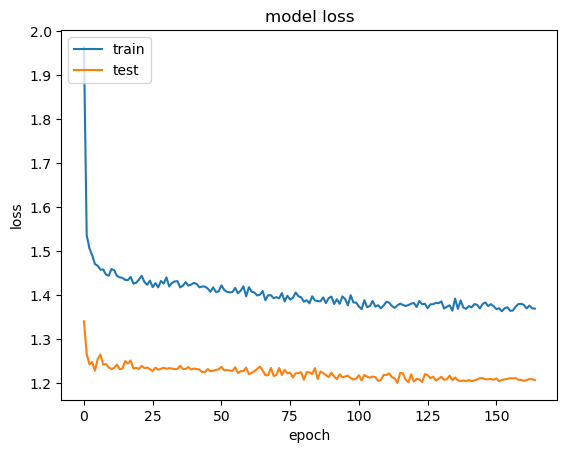

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
from keras.models import load_model
from jellyfish import damerau_levenshtein_distance, levenshtein_distance
import pandas as pd
import distance

modelname = os.path.basename(best_model_name.filepath)
model = load_model(f'./output_files/models/{modelname}')

X_test,y_test_a, y_test_t, y_test_tr = inbu.generating_inputs(OCEL=ocel_test,
                                                                  num_of_features=num_of_features,
                                                                  max_trace_length=max_trace_length,
                                                                  taf=target_act_feat,
                                                                  act=act_feat,
                                                                  custf=cust_feat,
                                                                  divisor_next=divisor,
                                                                  divisor_since=divisor2,
                                                                  divisor_remaining=divisorTR, 
                                                                  single= single_log,
                                                                  test = testing_other_remaining)

# y_t = y_t * divisor3

y = model.predict(X_test,verbose=1)
y_char = y[0][:][:]
y_t = y[1][:][:]
y_tr = y[2][:][:]
max_index_list = [np.argmax(pred) for pred in y_char]
pred_act_list = [target_act_feat_dict.get(item, item) for item in max_index_list]
y_t = np.maximum(y_t, 0)
y_t1 = y_t * divisor
y_tr1 = y_tr * divisorTR

columns_to_drop = [col for col in ocel_test.columns if 'Act_' in col] + \
                  [col for col in ocel_test.columns if 'Cust_' in col] + \
                  [ 'Customers', 'Next_Time_Since_Start',
                   'Next_Time_Since_Midnight', 'Next_Weekday', 
                   'Position', 'Time_Since_Midnight', 'Weekday'] + other_features

output_ocel = ocel_test.drop(columns=columns_to_drop).copy()
output_ocel['Pred_Activity'] = pred_act_list
output_ocel['Pred_Time_Diff'] = y_t1
output_ocel['Pred_Remaining_Time'] = y_tr1

output_ocel['Levenshtein'] = output_ocel.apply(lambda row: 1 - levenshtein_distance(row['Pred_Activity'], row['Next_Activity']), axis=1)
output_ocel['Damerau'] = output_ocel.apply(lambda row: 1 - (damerau_levenshtein_distance(row['Pred_Activity'], row['Next_Activity']) / max(len(row['Pred_Activity']), len(row['Next_Activity']))), axis=1)
output_ocel['Damerau'] = output_ocel['Damerau'].clip(lower=0)
output_ocel['Jaccard'] = output_ocel.apply(lambda row: 1 - distance.jaccard(row['Pred_Activity'], row['Next_Activity']), axis=1)

output_ocel
from sklearn import metrics
act_comp = output_ocel['Pred_Activity'] == output_ocel['Next_Activity'] 
print(sum(act_comp)/len(act_comp))
print(metrics.mean_absolute_error(output_ocel['Pred_Time_Diff']/ (24 * 60 * 60),output_ocel['Next_Time_Diff']/ (24 * 60 * 60)))
print(metrics.mean_absolute_error(output_ocel['Pred_Remaining_Time']/ (24 * 60 * 60),output_ocel['Next_Remaining_Time']/ (24 * 60 * 60)))
print(metrics.mean_squared_error(output_ocel['Pred_Time_Diff']/ (24 * 60 * 60),output_ocel['Next_Time_Diff']/ (24 * 60 * 60),squared=False))
print(metrics.mean_squared_error(output_ocel['Pred_Remaining_Time']/ (24 * 60 * 60),output_ocel['Next_Remaining_Time']/ (24 * 60 * 60),squared=False))

46/46 [==============================] - 1s 6ms/step
0.911906400550585
0.42627303927097804
0.3615423507476866
0.8612315102415721
0.8832796808587745


2.604857336903863
3.197816839635765
4.759801071662072
8.059703481044945

In [33]:
from jellyfish import damerau_levenshtein_distance, levenshtein_distance
import pandas as pd
import distance
from sklearn import metrics

# Generate inputs with varying prefix lengths
prefix_lengths = range(2, max_trace_length-1)  # List of prefix lengths to consider
results = []

for prefix_length in prefix_lengths:
    print(f"Results for Prefix Length {prefix_length}:")
    
    # Generate inputs with the current prefix length
    X_test, y_test_a, y_test_t, y_test_tr = inbu.generating_inputs(OCEL=ocel_test,
                                                                  num_of_features=num_of_features,
                                                                  max_trace_length=max_trace_length,
                                                                  taf=target_act_feat,
                                                                  act=act_feat,
                                                                  custf=cust_feat,
                                                                  divisor_next=divisor,
                                                                  divisor_since=divisor2,
                                                                  divisor_remaining=divisorTR,
                                                                  single=single_log,
                                                                  prefix_length=prefix_length,
                                                                  test = testing_other_remaining)

    # Make predictions with the model
    y = model.predict(X_test, verbose=1)
    y_char = y[0][:][:]
    y_t = y[1][:][:]
    y_tr = y[2][:][:]

    max_index_list = [np.argmax(pred) for pred in y_char]
    pred_act_list = [target_act_feat_dict.get(item, item) for item in max_index_list]
    y_t = np.maximum(y_t, 0)
    y_t1 = y_t * divisor
    y_tr1 = y_tr * divisorTR

    columns_to_drop = [col for col in ocel_test.columns if 'Act_' in col] + \
                    [col for col in ocel_test.columns if 'Cust_' in col] + \
                    [ 'Customers', 'Next_Time_Since_Start',
                    'Next_Time_Since_Midnight', 'Next_Weekday', 
                    'Position', 'Time_Since_Midnight', 'Weekday'] + other_features

    trace_length = ocel_test['Trace_Len'].values
    output_ocel = ocel_test[trace_length >= prefix_length].reset_index(drop= True).drop(columns=columns_to_drop).copy()
    output_ocel['Pred_Activity'] = pred_act_list
    output_ocel['Pred_Time_Diff'] = y_t1
    output_ocel['Pred_Remaining_Time'] = y_tr1

    output_ocel['Levenshtein'] = output_ocel.apply(lambda row: 1 - levenshtein_distance(row['Pred_Activity'], row['Next_Activity']), axis=1)
    output_ocel['Damerau'] = output_ocel.apply(lambda row: 1 - (damerau_levenshtein_distance(row['Pred_Activity'], row['Next_Activity']) / max(len(row['Pred_Activity']), len(row['Next_Activity']))), axis=1)
    output_ocel['Damerau'] = output_ocel['Damerau'].clip(lower=0)
    output_ocel['Jaccard'] = output_ocel.apply(lambda row: 1 - distance.jaccard(row['Pred_Activity'], row['Next_Activity']), axis=1)

    mae_time_diff = metrics.mean_absolute_error(output_ocel['Pred_Time_Diff']/ (24 * 60 * 60), output_ocel['Next_Time_Diff']/ (24 * 60 * 60)) 
    mae_remaining_time = metrics.mean_absolute_error(output_ocel['Pred_Remaining_Time']/ (24 * 60 * 60), output_ocel['Next_Remaining_Time']/ (24 * 60 * 60)) 
    rmse_time_diff = metrics.mean_squared_error(output_ocel['Pred_Time_Diff']/ (24 * 60 * 60), output_ocel['Next_Time_Diff']/ (24 * 60 * 60), squared=False) 
    rmse_remaining_time = metrics.mean_squared_error(output_ocel['Pred_Remaining_Time']/ (24 * 60 * 60), output_ocel['Next_Remaining_Time']/ (24 * 60 * 60), squared=False) 

    # Store the results for the current prefix length
    results.append({
        'Prefix Length': prefix_length,
        'length': len(y_tr),
        'MAE Time Difference': mae_time_diff,
        'MAE Remaining Time': mae_remaining_time,
        'RMSE Time Difference': rmse_time_diff,
        'RMSE Remaining Time': rmse_remaining_time
    })

    # Output additional values based on Case_ID and prefix length
    for case_id in output_ocel['Case_ID'].unique():
        case_data = output_ocel[output_ocel['Case_ID'] == case_id]
        trace_length = len(case_data)
        if prefix_length <= trace_length:
            # print(f"\nAdditional values for Prefix Length {prefix_length} and Case ID {case_id}:")
            case_data_prefix = case_data[:prefix_length]
            #print(case_data_prefix.to_string(index=False))
            
            mae_time_diff_case = metrics.mean_absolute_error(case_data_prefix['Pred_Time_Diff']/ (24 * 60 * 60), case_data_prefix['Next_Time_Diff']/ (24 * 60 * 60))
            mae_remaining_time_case = metrics.mean_absolute_error(case_data_prefix['Pred_Remaining_Time']/ (24 * 60 * 60), case_data_prefix['Next_Remaining_Time']/ (24 * 60 * 60))
            rmse_time_diff_case = metrics.mean_squared_error(case_data_prefix['Pred_Time_Diff']/ (24 * 60 * 60), case_data_prefix['Next_Time_Diff']/ (24 * 60 * 60), squared=False)
            rmse_remaining_time_case = metrics.mean_squared_error(case_data_prefix['Pred_Remaining_Time']/ (24 * 60 * 60), case_data_prefix['Next_Remaining_Time']/ (24 * 60 * 60), squared=False)
            
            # print(f"\nMetrics for Prefix Length {prefix_length} and Case ID {case_id}:")
            # print("MAE Time Difference:", mae_time_diff_case)
            # print("MAE Remaining Time:", mae_remaining_time_case)
            # print("RMSE Time Difference:", rmse_time_diff_case)
            # print("RMSE Remaining Time:", rmse_remaining_time_case)

# Output the overall results
df_results = pd.DataFrame(results)
print("\nOverall Results:")
print(df_results)


Results for Prefix Length 2:
46/46 [==============================] - 1s 3ms/step
Results for Prefix Length 3:
46/46 [==============================] - 0s 3ms/step
Results for Prefix Length 4:
13/13 [==============================] - 0s 3ms/step
Results for Prefix Length 5:
6/6 [==============================] - 0s 4ms/step
Results for Prefix Length 6:
3/3 [==============================] - 0s 5ms/step
Results for Prefix Length 7:
1/1 [==============================] - 0s 19ms/step

Overall Results:
   Prefix Length  length  MAE Time Difference  MAE Remaining Time   
0              2    1453             0.428736            0.363319  \
1              3    1453             0.419355            0.361841   
2              4     385             0.461207            0.735182   
3              5     165             0.515461            1.197850   
4              6      75             0.505075            1.404227   
5              7      15             0.524891            1.933658   

   RMSE Tim

Overall Results:
   Prefix Length  length  MAE Time Difference  MAE Remaining Time   
0              2    2148             2.618387            3.210506  \
1              3    2148             2.610200            3.178392   
2              4     510             5.189373            8.829667   
3              5     126             6.830172           16.141236   
4              6      31             7.683536           24.763984   
5              7       7             8.797930           35.491213   

   RMSE Time Difference  RMSE Remaining Time  
0              4.798312             8.495652  
1              4.756645             8.264313  
2              7.870040            15.821624  
3              9.429331            25.044045  
4             10.219038            35.647287  
5             11.258677            47.561489 